# hcq_retinophaty_prediction

## Import libraries and read data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest,f_classif
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
import imblearn
from imblearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ferdmartin/hcq_retinophaty_prediction/main/dummydata_rsf_7_20_22.csv')

## Exploring dataset

In [3]:
df.head()

,id,age,weight_kg,height_inch,eGFR,astmean,cumulative_dose,female,diabetes,tamoxifen,retinaltoxin,highdose,race,hcqindication,bmi,outcome,fup_time,dosewt
0,1,50,67.7,63,76.1,18.3,357.0,1,0,0,0,1,White,lupus,26.438702,0,120,6.257509
1,2,59,80.8,65,89.1,23.3,564.0,1,0,0,0,0,White,Other/Unknown,29.642663,0,41,4.855915
2,3,56,76.5,65,84.8,21.5,520.0,1,0,0,0,1,White,lupus,28.065145,0,6,6.342299
3,4,70,96.5,68,104.5,31.1,240.0,1,0,0,0,0,White,RA,32.347599,0,44,2.039484
4,5,59,80.5,65,88.8,23.2,568.0,1,0,0,0,1,White,Sjogrens syndrome,29.532603,1,12,5.070541


In [4]:
df.outcome.value_counts()
# Imbalanced

0    4032
1     119
Name: outcome, dtype: int64

In [5]:
df.isna().sum()
# No nulls

id                 0
age                0
weight_kg          0
height_inch        0
eGFR               0
astmean            0
cumulative_dose    0
female             0
diabetes           0
tamoxifen          0
retinaltoxin       0
highdose           0
race               0
hcqindication      0
bmi                0
outcome            0
fup_time           0
dosewt             0
dtype: int64

In [6]:
df.describe()

,id,age,weight_kg,height_inch,eGFR,astmean,cumulative_dose,female,diabetes,tamoxifen,retinaltoxin,highdose,bmi,outcome,fup_time,dosewt
count,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000
mean,2076.000000,57.082390,79.198699,64.804384,85.953361,23.880029,490.597360,0.825584,0.065285,0.003614,0.011082,0.387377,28.773014,0.028668,67.933510,4.503707
std,1198.434813,13.563593,19.655275,3.617600,19.978272,9.482674,170.307368,0.379512,0.247059,0.060012,0.104697,0.487210,4.689372,0.166891,39.117154,1.974297
min,1.000000,22.000000,35.400000,53.000000,18.600000,6.300000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.633505,0.000000,1.000000,0.068902
25%,1038.500000,48.000000,65.100000,62.000000,72.400000,17.200000,362.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.806503,0.000000,33.000000,3.021613
50%,2076.000000,57.000000,78.700000,65.000000,86.200000,22.200000,508.000000,1.000000,0.000000,0.000000,0.000000,0.000000,28.982306,0.000000,64.000000,4.357873
75%,3113.500000,66.000000,92.300000,67.000000,99.800000,28.600000,644.000000,1.000000,0.000000,0.000000,0.000000,1.000000,31.744224,0.000000,110.000000,5.869446
max,4151.000000,94.000000,146.500000,77.000000,136.400000,77.900000,720.000000,1.000000,1.000000,1.000000,1.000000,1.000000,66.178116,1.000000,120.000000,12.236907


## Preparing our dataset for modelling

In [7]:
X, y = df.drop('outcome', axis=1), df.outcome

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [9]:
ohe = OneHotEncoder()
cat_cols = X_train.select_dtypes(include='object').columns
num_columns = X_train.drop(cat_cols, axis=1).columns.tolist()

X_train = pd.concat([pd.DataFrame(ohe.fit_transform(X_train[cat_cols]).toarray()), 
                     X_train.drop(cat_cols, axis=1).reset_index(drop=True)], axis=1)

X_test = pd.concat([pd.DataFrame(ohe.transform(X_test[cat_cols]).toarray()), 
                     X_test.drop(cat_cols, axis=1).reset_index(drop=True)], axis=1)

cat_cols = ohe.get_feature_names_out().tolist()
cols = num_columns + cat_cols
X_train.columns = cols
X_test.columns = cols

y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
X_train = X_train.drop('id', axis=1); X_test = X_test.drop('id', axis=1); 

In [10]:
std_scaler = StandardScaler()
X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

In [11]:
# Random Forest Classifier
RF = RandomForestClassifier(n_jobs=-1)
# Cross Validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)

## Feature Selection

In [12]:
# Feature selection
## Forward
fs_Forward = SequentialFeatureSelector(estimator=RF, cv=cv, scoring='f1', direction='forward')
fs_Forward.fit(X_train, y_train)
## Backward
fs_Backward = SequentialFeatureSelector(estimator=RF, cv=cv, scoring='f1', direction='backward')
fs_Backward.fit(X_train, y_train)
## Wrapper
fs_Wrapper = RFECV(estimator=RF, cv=cv, scoring='f1', min_features_to_select=1)
fs_Wrapper.fit(X_train, y_train)
# ANOVA
fs_anova = SelectKBest(score_func=f_classif, k=X_train.shape[1]//2)
fs_anova.fit(X_train, y_train);

### Best Feature Selection Method

In [13]:
# Select best feature selection method
fs_methods = [None, fs_Forward, fs_Backward, fs_Wrapper, fs_anova]
fs_score = 0
fs_columns = X_train.columns
best_fs_method = None
for fs_method in fs_methods:
    if fs_method is None:
        cvs = cross_val_score(estimator=RF, X=X_train, y=y_train, scoring='f1', cv=cv)
        cvs_score = np.mean(cvs)
    else:
        cvs = cross_val_score(estimator=RF, X=X_train[fs_method.get_feature_names_out()], 
                              y=y_train, scoring='f1', cv=cv)
        cvs_score = np.mean(cvs)
        
    if cvs_score > fs_score:
        fs_score = cvs_score
        best_fs_method = fs_method
        fs_columns = fs_method.get_feature_names_out()

## Imbalaced Data Treatment

In [14]:
class imbalanced_technique:
    def __init__(self, technique, estimator, metric, cv, X, y):
        self.name = 'None' if metric is None else str(technique.__class__())
        self.technique = technique; self.estimator = estimator
        self.metric = metric; self.cv = cv
        if self.technique is None:
            self.model_pipeline = self.estimator
        elif str(self.technique.__class__()) == 'BaggingClassifier()':
            self.model_pipeline = technique
        else:
            self.model_pipeline = make_pipeline(self.technique, self.estimator)
        self.cvs = cross_val_score(self.model_pipeline, X=X, y=y, 
                                   scoring=self.metric, cv=self.cv)
        self.avg_score = np.mean(self.cvs)

In [15]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
undersampling = imblearn.under_sampling.RandomUnderSampler()
oversampling = imblearn.over_sampling.RandomOverSampler()
smote = imblearn.over_sampling.SMOTE()
bagging = BaggingClassifier(base_estimator=RF)
imb_techniques = []
imb_techniques.append(imbalanced_technique(None, RF, 'f1', cv, X_train[fs_columns], y_train))
imb_techniques.append(imbalanced_technique(undersampling, RF, 'f1', cv, X_train[fs_columns], y_train))
imb_techniques.append(imbalanced_technique(oversampling, RF, 'f1', cv, X_train[fs_columns], y_train))
imb_techniques.append(imbalanced_technique(smote, RF, 'f1', cv, X_train[fs_columns], y_train))
imb_techniques.append(imbalanced_technique(bagging, RF, 'f1', cv, X_train[fs_columns], y_train))

### Best Technique

In [16]:
best_imb_technique = None
best_imb_score = 0
for imb_technique in imb_techniques:
    if imb_technique.avg_score > best_imb_score:
        best_imb_technique = imb_technique
        best_imb_score = imb_technique.avg_score

## Hyperparameter Tuning

In [17]:
# Grid search Random Forest
param_grid_RF = {'randomforestclassifier__n_estimators': [100, 200, 400, 600, 800],  # Number of estimators
                 'randomforestclassifier__criterion': ['gini', 'entropy'], # Calculate Information Gain
                 'randomforestclassifier__bootstrap': [True, False] # sampling for each training tree               
                }
tuned_RF = GridSearchCV(best_imb_technique.model_pipeline, 
                       param_grid=param_grid_RF, scoring = 'f1', cv = cv)
tuned_RF.fit(X_train[fs_columns], y_train);

## Results

In [18]:
preds = tuned_RF.predict(X_test[fs_columns])
preds_proba = tuned_RF.predict_proba(X_test[fs_columns])

In [19]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
metrics = {'F1': round(f1_score(y_test, preds), 4),
          'Precision': round(precision_score(y_test, preds), 4),
          'Recall': round(recall_score(y_test, preds), 4),
          'Accuracy':round(accuracy_score(y_test, preds), 4)}
pd.DataFrame([metrics])

,F1,Precision,Recall,Accuracy
0,0.0581,0.0304,0.6522,0.4152


In [20]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.41      0.58       808
           1       0.03      0.65      0.06        23

    accuracy                           0.42       831
   macro avg       0.50      0.53      0.32       831
weighted avg       0.95      0.42      0.56       831



In [21]:
# Top Predictors
top_predictors = dict(zip(tuned_RF.feature_names_in_, 
                          tuned_RF.best_estimator_['randomforestclassifier'].feature_importances_))
top_predictors = {key: val for key, val in sorted(top_predictors.items(), key= lambda x: x[1], reverse=True)}

In [22]:
top_predictor_df = pd.DataFrame([top_predictors]).transpose()
top_predictor_df.columns = ['Importance']

In [23]:
top_predictor_df

,Importance
diabetes,1.0


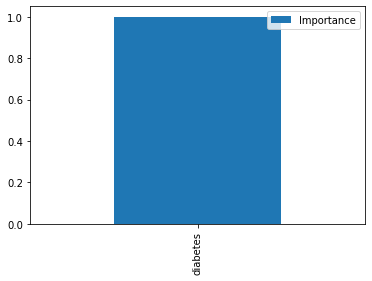

In [24]:
top_predictor_df.plot.bar();